**SPATIAL ANALYSIS (BUS)**

In this part, we will try to create a spatial analysis of bus passenger flows during the whole period, by extracting the data for each municipality of the Lyon metropolis.

The first step consists in listing all the municipalities of the Lyon metropolis.

> Please note that some executions may take a very long time (up to 50 minutes). 
> This notebook is intended as a critical analysis and an opening, and should therefore be considered as a secondary

In [18]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path

# Use project repository as fallback
BASE_PATH = Path.cwd().parent / "data" / "spatial_analysis"

BDTOPO69M_PATH = BASE_PATH / "BD_TOPO_69M"
METROPOLE_DATA = BASE_PATH / "metropole_lyon" / "metropole_lyon.csv"
BUS_DATA = BASE_PATH.parent / "bus_indiv_15min" / "bus_indiv_15min.csv"
REF_BUS = BASE_PATH / "ref_tram_bus.csv"

metro_lyon = ["Lyon","Albigny-sur-Saône","Bron","Cailloux-sur-Fontaines","Caluire-et-Cuire","Champagne-au-Mont-d'Or","Charbonnières-les-Bains","Charly","Chassieu","Collonges-au-Mont-d'Or","Corbas","Couzon-au-Mont-d'Or","Craponne","Curis-au-Mont-d'Or","Dardilly","Décines-Charpieu","Écully","Feyzin",
"Fleurieu-sur-Saône","Fontaines-Saint-Martin","Fontaines-sur-Saône","Francheville","Genay","Givors","Grigny-sur-Rhône",
"Irigny","Jonage","Limonest","Lissieu","Marcy-l'Étoile","Meyzieu","Mions","Montanay","La Mulatière","Neuville-sur-Saône","Oullins-Pierre-Bénite","Poleymieux-au-Mont-d'Or","Quincieux","Rillieux-la-Pape",
"Rochetaillée-sur-Saône","Saint-Cyr-au-Mont-d'Or","Saint-Didier-au-Mont-d'Or","Sainte-Foy-lès-Lyon","Saint-Fons","Saint-Genis-Laval","Saint-Genis-les-Ollières","Saint-Germain-au-Mont-d'Or",
"Saint-Priest","Saint-Romain-au-Mont-d'Or","Sathonay-Camp","Sathonay-Village","Solaize","Tassin-la-Demi-Lune","La Tour-de-Salvagny","Vaulx-en-Velin","Vénissieux","Vernaison","Villeurbanne"]

We also have to import the bdtopo data, as they contain spatial information by municipality, whereas the bus data contains only the localisation of each station

In [19]:
def import_bdtopo (layer, path=BDTOPO69M_PATH):
    """
    Import a layer from the BD TOPO dataset as a GeoDataFrame.
    
    Parameters:
    layer (str): The name of the layer to import (e.g., 'batiment', 'voie', etc.).
    path (str): The path to the directory containing the BD TOPO shapefiles.
    
    Returns:
    gpd.GeoDataFrame: The imported layer as a GeoDataFrame.
    """
    file_path = BDTOPO69M_PATH / f"{layer}_69M.gpkg"

    gdf = gpd.read_file(file_path)
    return gdf

gdf_commune = import_bdtopo("communes")

Furthermore, because we don't have the names of the municipalities in our geodataframe, we import a new table with names that can be joined with the INSEE code.

This data is available here : 

https://data.grandlyon.com/portail/fr/jeux-de-donnees/communes-de-la-metropole-de-lyon--a-partir-de-2024/telechargements


In [20]:
#Import a new dataframe metropole that contains names of municipalities
metropole = pd.read_csv(METROPOLE_DATA,sep=';')
metropole['insee']=metropole['insee'].astype('object')

#Join it to gdf_commune by using the insee code
dictionary=pd.Series(metropole['nom'].values,index=metropole['insee']).to_dict()
gdf_commune['cleabs']=[dictionary[int(i)] for i in gdf_commune['code_insee']]

#Convert the CRS of gdf_commune
gdf_commune=gdf_commune.to_crs(4326)

Then we import the bus data

In [21]:
df = pd.read_csv(BUS_DATA,index_col = 0,low_memory=False)
dfs={}

if 'VAL_DATE' in df.columns:
    df['VAL_DATE'] = pd.to_datetime(df['VAL_DATE']) 
else: 
    df.index = pd.to_datetime(df.index)
dfs['bus']= df

ref_tram_bus = pd.read_csv(REF_BUS,index_col = 0).rename(columns = {'IDT_PNT' : 'VAL_ARRET_CODE','COO_X_WGS84':'lon','COO_Y_WGS84':'lat'})

ref_tram_bus = ref_tram_bus[['lon','lat','NOM_PNT','VAL_ARRET_CODE']]

df_bus = dfs["bus"].merge(ref_tram_bus, how = 'inner', on = 'VAL_ARRET_CODE') 

Now we can merge the municipality information from gdf_commune in df_bus. Indeed, we have coordinates (longitude and latitude) for each bus station, and we can determine to which commune this station belongs

In [ ]:
communes_dict=pd.Series(gdf_commune['geometry'].values,index=gdf_commune['cleabs']).to_dict()
df_bus['geometry']=gpd.points_from_xy(df_bus['lon'],df_bus['lat'])
for com in communes_dict.keys():
    df_bus[com]=communes_dict[com].contains(df_bus['geometry'])

For some municipalities, we don't have any information on bus travels. This is why we decide to remove them

In [ ]:
remove=["Curis-au-Mont-d'Or","Genay","Montanay","Quincieux","Poleymieux-au-Mont-d'Or","La Tour-de-Salvagny","Saint-Didier-au-Mont-d'Or"]
metro_lyon_filtered=[com for com in metro_lyon if com not in remove]

Then we can plot the chronology of flows during our time period (from 2019-11 to 2020-04) for each municipality.
Because we are interested in the relative changings in these flows, we decided to normalize all the flows by taking the min and the max for each municipality

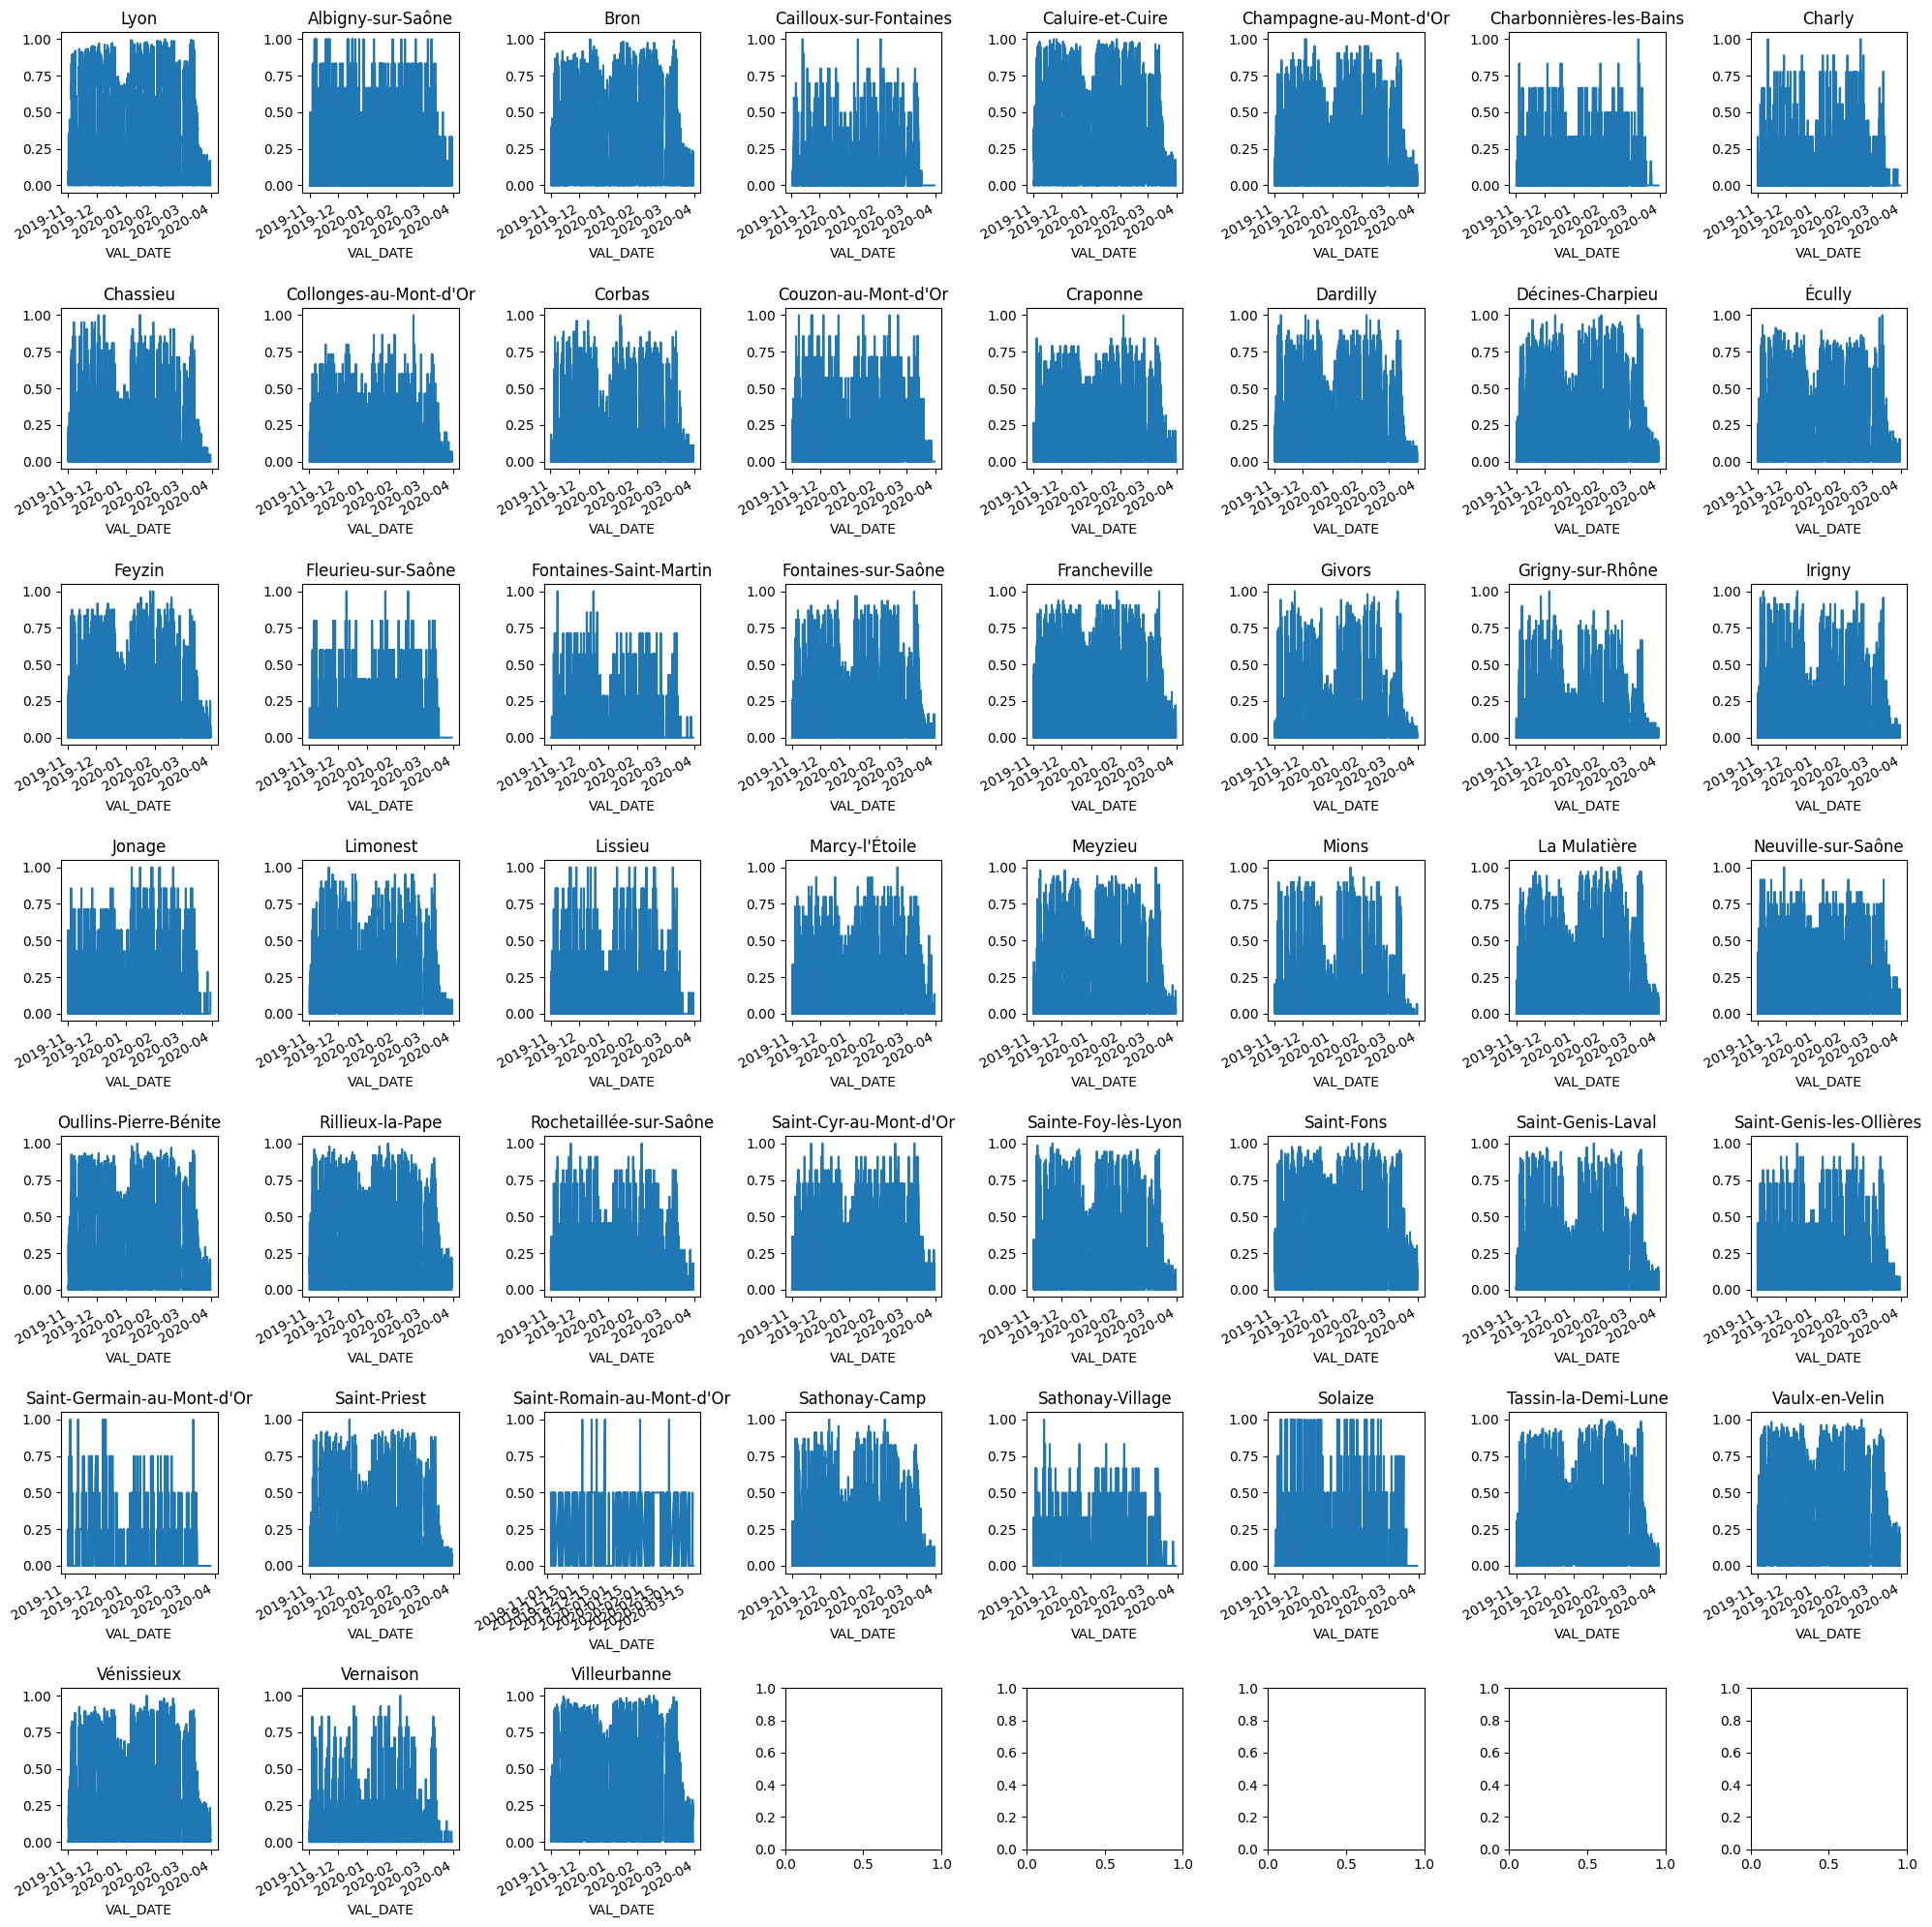

In [ ]:
fig,axs=plt.subplots(nrows=7,ncols=8,figsize=(20,20))
axs=axs.flatten()
for index,com in enumerate(metro_lyon_filtered):
    df_com=df_bus[df_bus[com]==True]# & (df_bus['VAL_DATE']<=day_end)]
    x=df_com.groupby(['VAL_DATE'])['Flow'].count()
    ((x-x.min())/(x.max()-x.min())).plot(ax=axs[index])
    axs[index].set_title(com)
plt.tight_layout()

Now, we can process to create a distance matrix with all the data that we have collected.
To calculate the distance, we decided to use the following relation : 


```math
\frac{\sqrt{\sum_{i=0}^{n}(x_{i}-y_{i})^2}}{\sqrt{\sum_{i=0}^{n}(\max(x_{i},y_{i}))^2}}
```

In [ ]:
import numpy as np
df_distance=pd.DataFrame(index=metro_lyon_filtered,columns=metro_lyon_filtered)
for i in df_distance.index:
    for j in df_distance.columns:
        X=pd.DataFrame(df_bus[df_bus[i]==True].groupby(['VAL_DATE'])['Flow'].count(),df_bus['VAL_DATE'].unique()).sort_index()
        Y=pd.DataFrame(df_bus[df_bus[j]==True].groupby(['VAL_DATE'])['Flow'].count(),df_bus['VAL_DATE'].unique()).sort_index()
        X[X.isna()]=0
        Y[Y.isna()]=0
        df_distance.loc[i,j]=np.sqrt(sum((X['Flow'] - Y['Flow']) ** 2))/np.sqrt(sum(pd.concat([X,Y],axis=1).max(axis=1)**2))
df_distance

,Lyon,Albigny-sur-Saône,Bron,Cailloux-sur-Fontaines,Caluire-et-Cuire,Champagne-au-Mont-d'Or,Charbonnières-les-Bains,Charly,Chassieu,Collonges-au-Mont-d'Or,...,Saint-Priest,Saint-Romain-au-Mont-d'Or,Sathonay-Camp,Sathonay-Village,Solaize,Tassin-la-Demi-Lune,Vaulx-en-Velin,Vénissieux,Vernaison,Villeurbanne
Lyon,0.0,0.996928,0.888341,0.998286,0.882481,0.988106,0.9983,0.998371,0.989959,0.9943,...,0.93701,0.999742,0.987572,0.998945,0.998859,0.936217,0.868059,0.9069,0.997433,0.76891
Albigny-sur-Saône,0.996928,0.0,0.973123,0.757993,0.974104,0.78867,0.727614,0.758067,0.764497,0.669485,...,0.952435,0.954587,0.795503,0.820719,0.811688,0.953203,0.977224,0.967242,0.706621,0.986951
Bron,0.888341,0.973123,0.0,0.984834,0.167606,0.895743,0.985009,0.985675,0.911236,0.949864,...,0.456497,0.9978,0.890737,0.99067,0.989883,0.454703,0.217266,0.22258,0.977496,0.531711
Cailloux-sur-Fontaines,0.998286,0.757993,0.984834,0.0,0.985332,0.873591,0.699437,0.777363,0.855751,0.804295,...,0.971458,0.939035,0.877666,0.736463,0.761798,0.972489,0.987259,0.981337,0.754767,0.9928
Caluire-et-Cuire,0.882481,0.974104,0.167606,0.985332,0.0,0.900483,0.985448,0.985989,0.915429,0.951774,...,0.481014,0.997818,0.894989,0.990934,0.990058,0.472925,0.187737,0.247153,0.977827,0.502553
Champagne-au-Mont-d'Or,0.988106,0.78867,0.895743,0.873591,0.900483,0.0,0.876794,0.889332,0.421347,0.63129,...,0.816354,0.978618,0.409882,0.920457,0.914882,0.817656,0.913096,0.874615,0.824715,0.950245
Charbonnières-les-Bains,0.9983,0.727614,0.985009,0.699437,0.985448,0.876794,0.0,0.763598,0.856101,0.789627,...,0.972785,0.938079,0.876034,0.732692,0.746571,0.973347,0.987404,0.981726,0.758913,0.992818
Charly,0.998371,0.758067,0.985675,0.777363,0.985989,0.889332,0.763598,0.0,0.875362,0.820181,...,0.974062,0.96898,0.882237,0.822247,0.783439,0.974659,0.987783,0.98239,0.741722,0.993054
Chassieu,0.989959,0.764497,0.911236,0.855751,0.915429,0.421347,0.856101,0.875362,0.0,0.588836,...,0.842776,0.978781,0.434287,0.908283,0.898998,0.845178,0.925787,0.893296,0.796212,0.957847
Collonges-au-Mont-d'Or,0.9943,0.669485,0.949864,0.804295,0.951774,0.63129,0.789627,0.820181,0.588836,0.0,...,0.911703,0.965879,0.624484,0.861739,0.841338,0.91278,0.957563,0.939158,0.698484,0.975707


We can also study the link between the population of each municipality and the distance from the others.
To do so, we need to get the population information in gdf_commune

In [ ]:
gdf_commune_filtered=gdf_commune[~gdf_commune.cleabs.isin(remove)]
communes_sorted=gdf_commune_filtered.sort_values(by='population',ascending=False)['cleabs']
df_distance_sorted=df_distance.reindex(index=communes_sorted,columns=communes_sorted)

Then we can plot the distances of each municipality to all the others

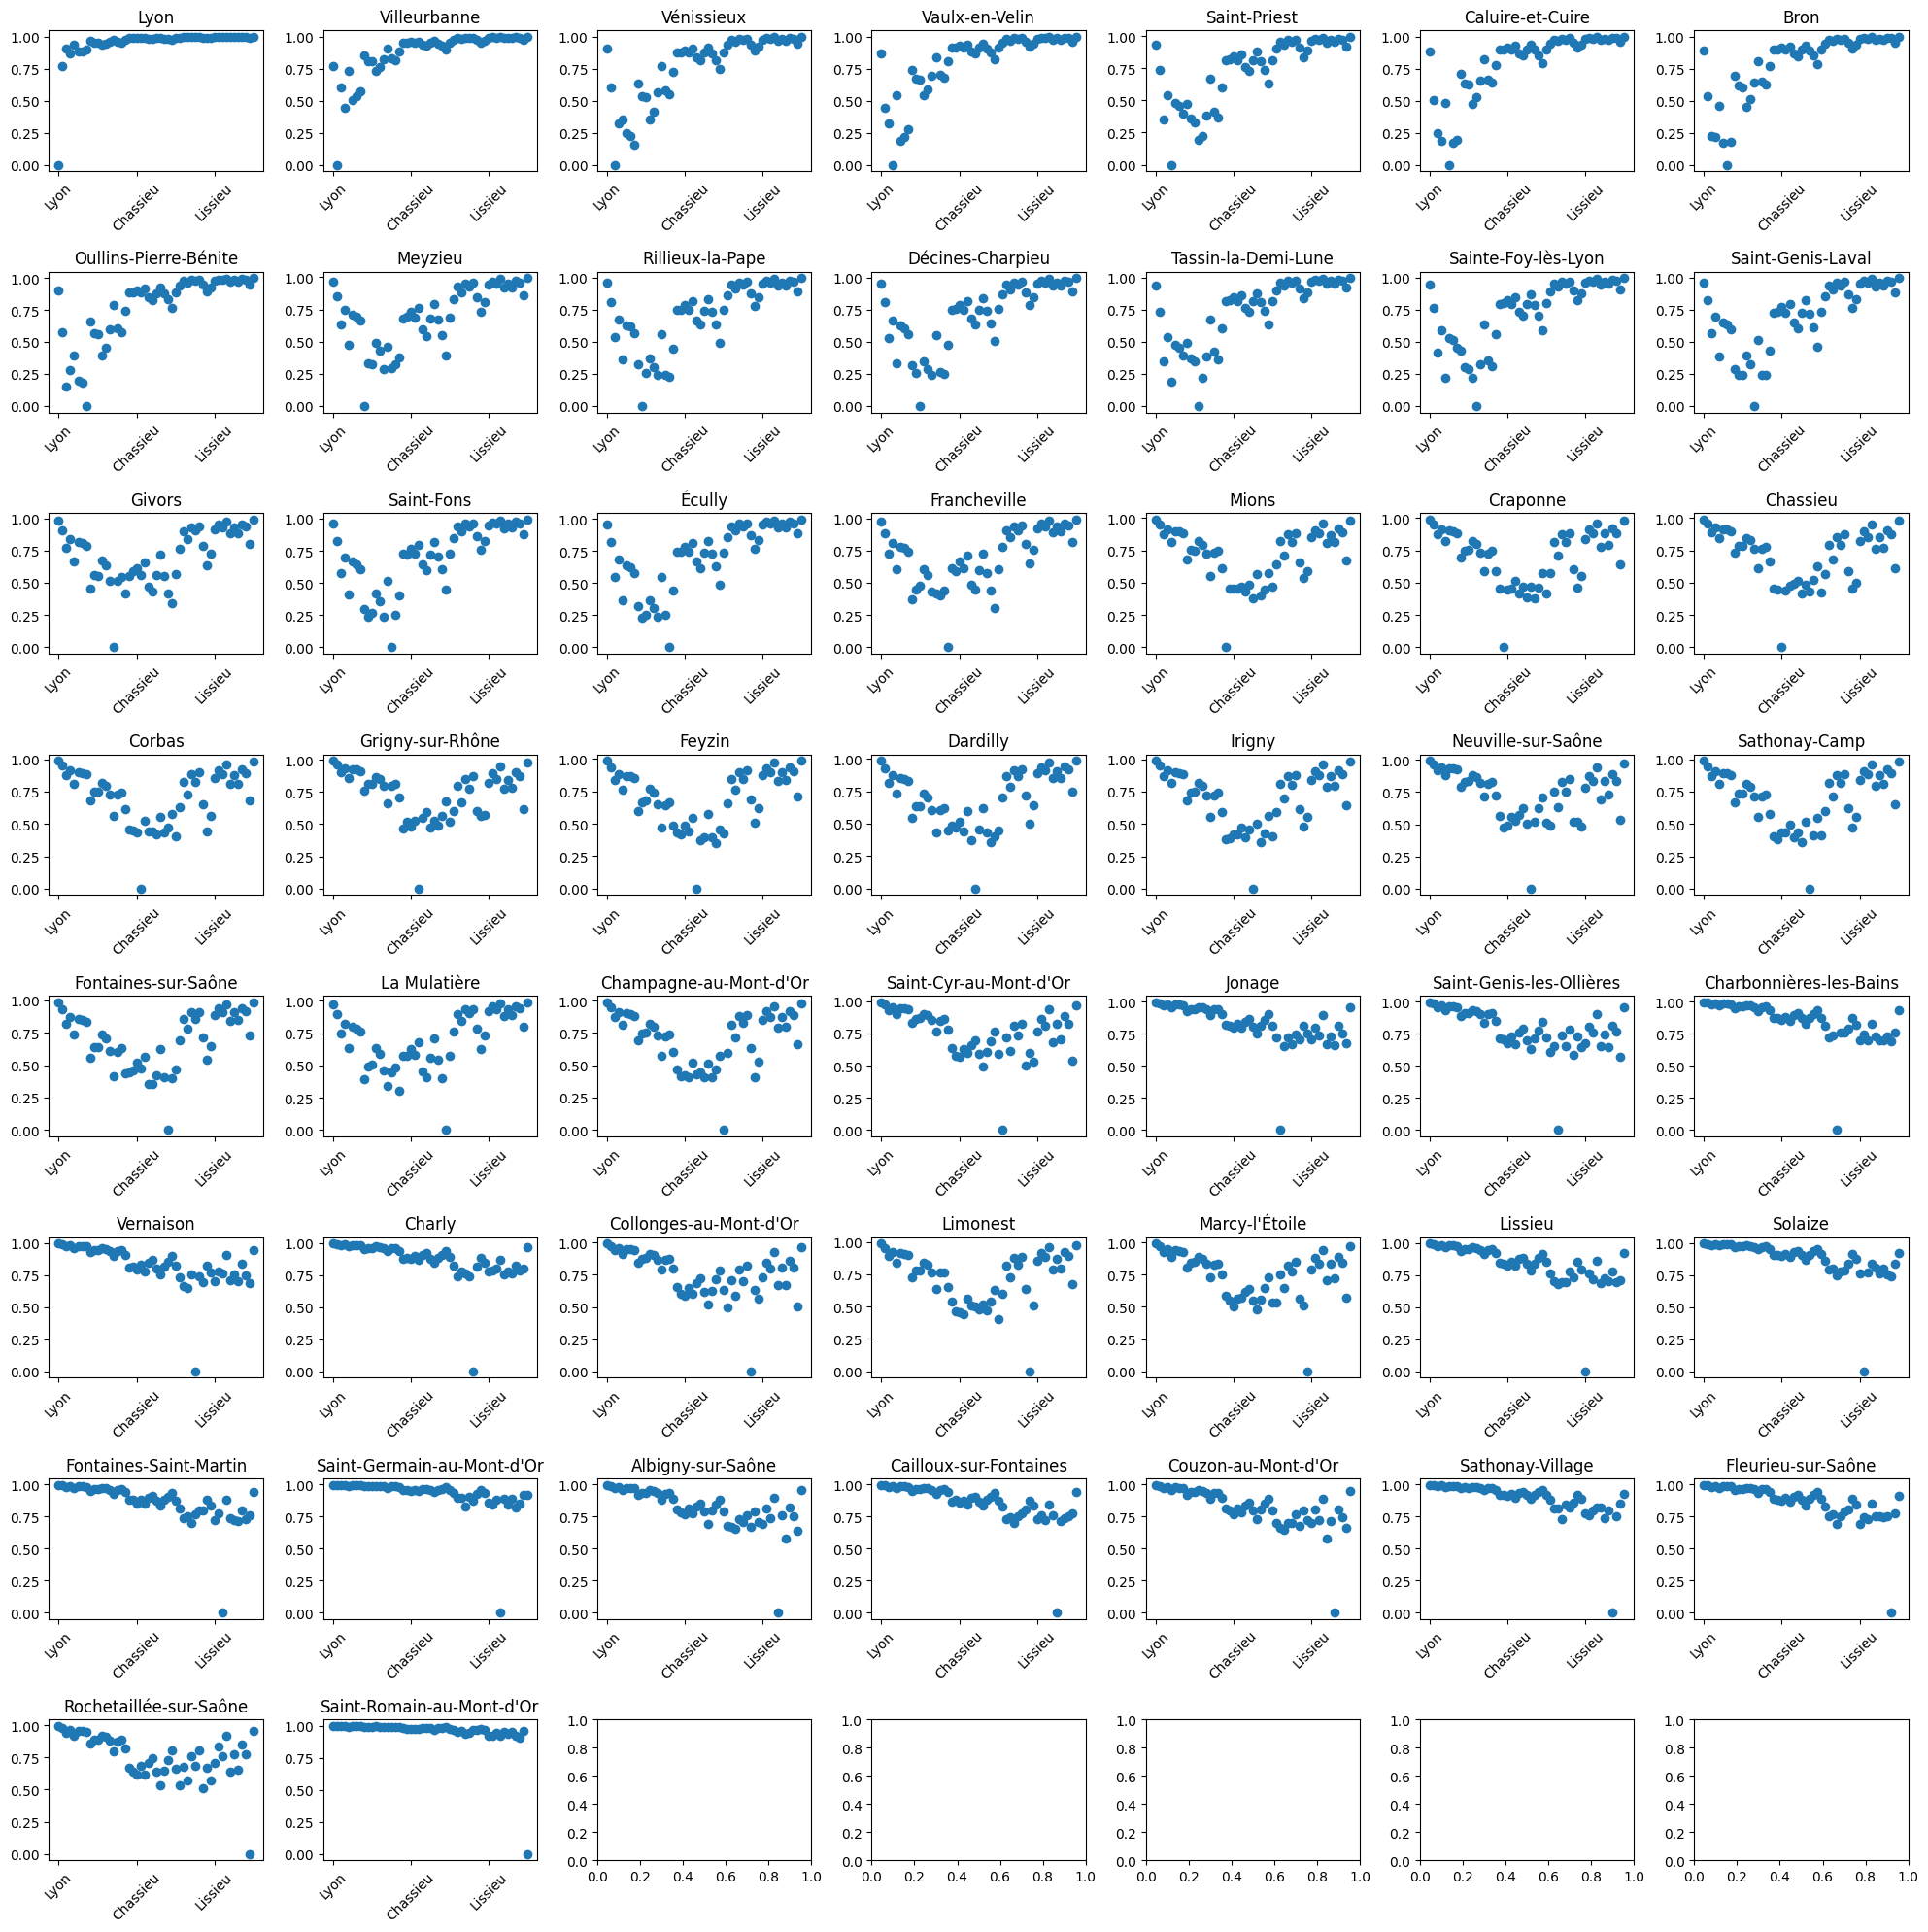

In [ ]:
fig,axs=plt.subplots(nrows=8,ncols=7,figsize=(20,20))
axs=axs.flatten()
for index,com in enumerate(list(df_distance_sorted.columns.values)):
    df_distance_sorted[com].plot(style='o',rot=45,title=com,ax=axs[index],xlabel='')
    axs[index].set_title(com)

plt.tight_layout()

We can observe that municipalities are closer from the ones that have a quite similar population.
This is why we can try to create a clustering to observe different categories of municipalities, because our initial aim is to check if it is accurrate to consider the whole metropolis as a unique entity.
To do so, we just need to use the linkage function (from scipy) with the distance matrix we have created

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2732\4225252993.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  complete_clustering = linkage(df_distance_sorted, method="complete", metric="euclidean")


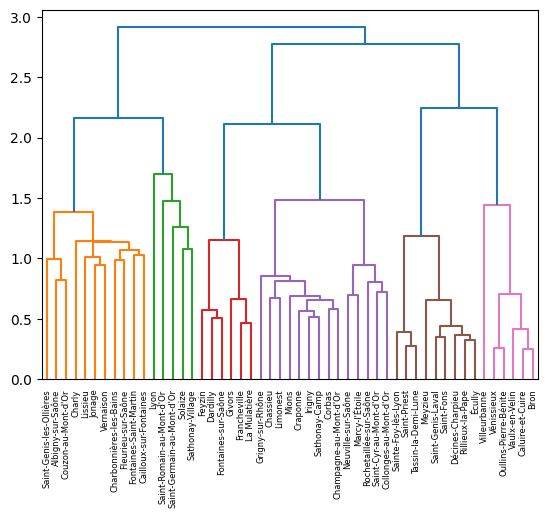

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
complete_clustering = linkage(df_distance_sorted, method="complete", metric="euclidean")
dendrogram(complete_clustering,labels=list(df_distance_sorted.columns.values))
plt.show()